Initial Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB

First 5 Rows:
    Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    258

Calculating Travel Distances: 100%|██████████| 200000/200000 [00:02<00:00, 71225.83it/s]


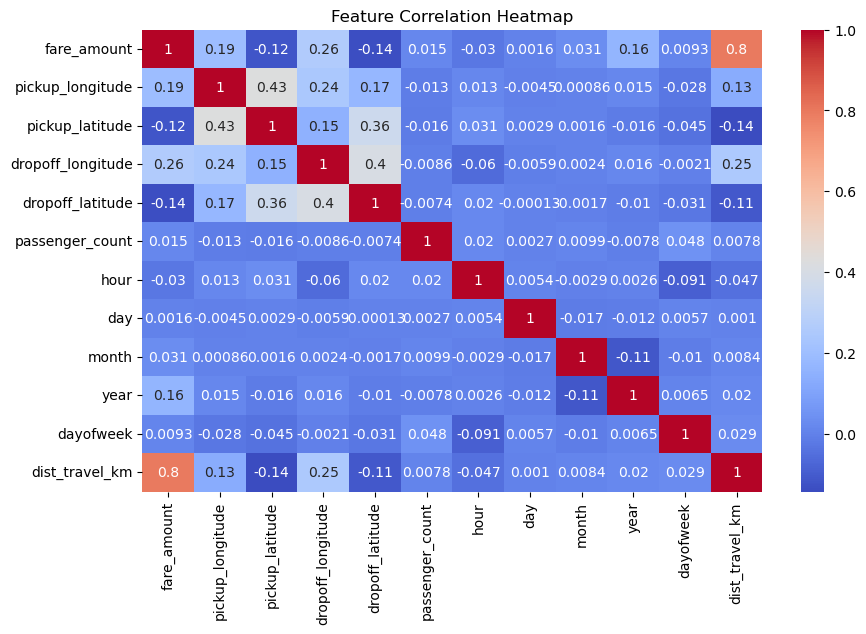

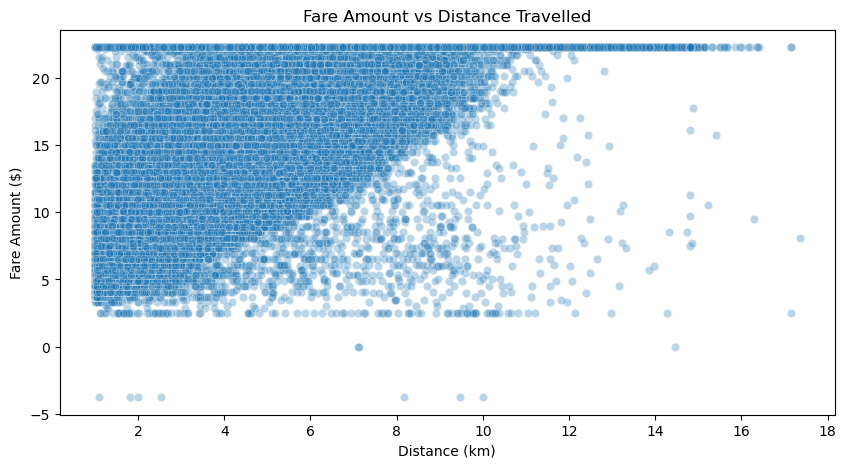

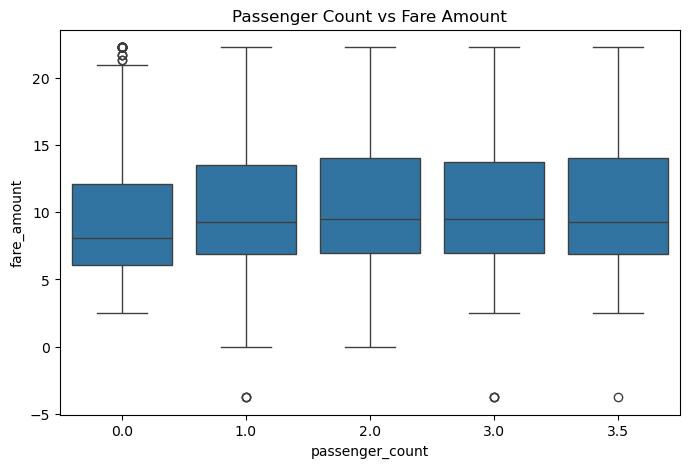


Intercept: 3873.3450434047086
Coefficients:
 [ 2.81356266e+01 -7.15666631e+00  2.14636851e+01 -1.86448315e+01
  6.42777987e-02  8.31489018e-03  1.88609990e-03  6.40521034e-02
  4.23471741e-01 -4.04389679e-02  1.80356070e+00]

Model Evaluation Results:
R² Score: 0.6771
Mean Squared Error: 9.2573
Root Mean Squared Error: 3.0426


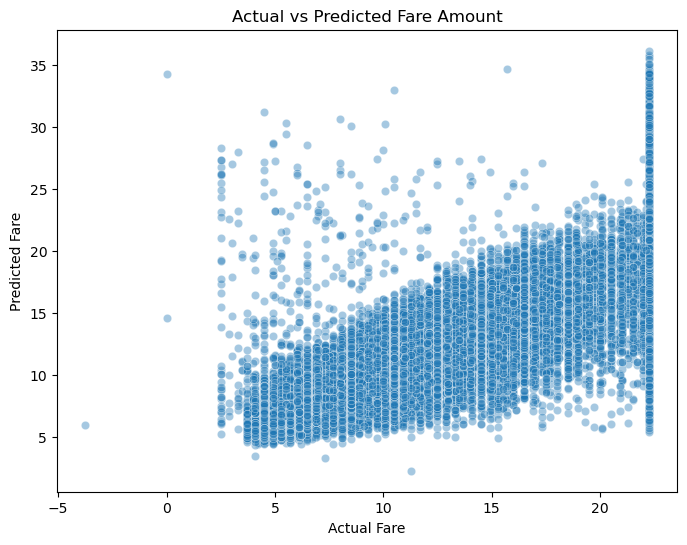


Sample Predictions:
         Actual  Predicted
84906      8.1   7.849607
197858    11.0  10.382332
159216    10.9  11.223362
125619    15.7   8.993720
19806     11.0  13.978648

Model saved as 'uber_fare_model.pkl'


In [4]:
# ============================================================
# 🚕 UBER FARE PREDICTION - COMPLETE & CLEAN VERSION
# ============================================================

# --- Importing Libraries ---
!pip install haversine

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import haversine as hs  # pip install haversine
from tqdm import tqdm  # pip install tqdm

# ============================================================
# STEP 1: LOAD & INSPECT DATA
# ============================================================

# --- Load Dataset ---
df = pd.read_csv(r"C:\Users\Gayatri\Downloads\archive\uber.csv")

# --- Display Basic Info ---
print("Initial Data Info:\n")
df.info()

# --- Preview Data ---
print("\nFirst 5 Rows:\n", df.head())

# ============================================================
# STEP 2: DATA CLEANING & HANDLING MISSING VALUES
# ============================================================

# --- Drop Unnecessary Columns ---
df.drop(['Unnamed: 0', 'key'], axis=1, inplace=True)

# --- Check for Missing Values ---
print("\nMissing Values Before Cleaning:\n", df.isnull().sum())

# --- Fill Missing Values Safely ---
df.fillna({
    'dropoff_latitude': df['dropoff_latitude'].mean(),
    'dropoff_longitude': df['dropoff_longitude'].median()
}, inplace=True)

print("\nMissing Values After Cleaning:\n", df.isnull().sum())

# ============================================================
# STEP 3: FEATURE ENGINEERING
# ============================================================

# --- Convert Datetime Column ---
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

# --- Extract Useful Time-Based Features ---
df = df.assign(
    hour=df['pickup_datetime'].dt.hour,
    day=df['pickup_datetime'].dt.day,
    month=df['pickup_datetime'].dt.month,
    year=df['pickup_datetime'].dt.year,
    dayofweek=df['pickup_datetime'].dt.dayofweek
)

# --- Drop Original Datetime Column ---
df.drop('pickup_datetime', axis=1, inplace=True)

# ============================================================
# STEP 4: HANDLE OUTLIERS
# ============================================================

def remove_outlier(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], lower, upper)
    return df

for column in df.select_dtypes(include=['float64', 'int64']).columns:
    df = remove_outlier(df, column)

# ============================================================
# STEP 5: COMPUTE DISTANCE USING HAVERSINE FORMULA
# ============================================================

travel_dist = []
for i in tqdm(range(len(df)), desc="Calculating Travel Distances"):
    loc1 = (df.at[i, 'pickup_latitude'], df.at[i, 'pickup_longitude'])
    loc2 = (df.at[i, 'dropoff_latitude'], df.at[i, 'dropoff_longitude'])
    dist = hs.haversine(loc1, loc2)
    travel_dist.append(dist)

df['dist_travel_km'] = travel_dist

# --- Filter Unrealistic Distances ---
df = df.loc[(df['dist_travel_km'] >= 1) & (df['dist_travel_km'] <= 130)]

# --- Remove Invalid Coordinates ---
df = df.loc[
    (df['pickup_latitude'].between(-90, 90)) &
    (df['dropoff_latitude'].between(-90, 90)) &
    (df['pickup_longitude'].between(-180, 180)) &
    (df['dropoff_longitude'].between(-180, 180))
]

# ============================================================
# STEP 6: EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================

# --- Correlation Heatmap ---
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# --- Visualize Relationships ---
plt.figure(figsize=(10, 5))
sns.scatterplot(x='dist_travel_km', y='fare_amount', data=df, alpha=0.3)
plt.title("Fare Amount vs Distance Travelled")
plt.xlabel("Distance (km)")
plt.ylabel("Fare Amount ($)")
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(x='passenger_count', y='fare_amount', data=df)
plt.title("Passenger Count vs Fare Amount")
plt.show()

# ============================================================
# STEP 7: MODEL PREPARATION
# ============================================================

# --- Feature Selection ---
X = df[['pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude',
        'passenger_count', 'hour', 'day', 'month',
        'year', 'dayofweek', 'dist_travel_km']]

y = df['fare_amount']

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# ============================================================
# STEP 8: MODEL TRAINING (LINEAR REGRESSION)
# ============================================================

regressor = LinearRegression()
regressor.fit(X_train, y_train)

# --- Model Parameters ---
print("\nIntercept:", regressor.intercept_)
print("Coefficients:\n", regressor.coef_)

# ============================================================
# STEP 9: MODEL EVALUATION
# ============================================================

y_pred = regressor.predict(X_test)

# --- Evaluation Metrics ---
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("\nModel Evaluation Results:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

# --- Visualization of Predictions ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Actual vs Predicted Fare Amount")
plt.show()

# ============================================================
# STEP 10: RESULTS & SAVING MODEL
# ============================================================

# --- Compare Actual vs Predicted ---
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print("\nSample Predictions:\n", result_df.head())

# --- Save Model (optional) ---
import joblib
joblib.dump(regressor, "uber_fare_model.pkl")
print("\nModel saved as 'uber_fare_model.pkl'")
